In [15]:


#!/usr/bin/env python
# coding: utf-8

import sys  # to put the SCM into the PYTHONPATH

sys.path.append('../../library/F2PY')


###########################################
# Imports
###########################################
from sys import exit
import time as TIME
import xarray as xr
from scipy.interpolate import interp1d
import scipy.signal
from scm_class import SCM
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from case_configs import case_params

###################################################
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.facecolor': 'white'})
plt.rcParams.update({'savefig.facecolor': 'white'})
###########################################


# colors
blue, orange, magenta, grey, green = '#0db4c3', '#eea021', '#ff0364', '#606172', '#3fb532'

# ===========================================================================
case = 'WANG1_FR'


saving_path = '../figures/'
saving_name = case+'_profile_LES_vs_EDMF.png'


# loading LES output once before using the function

file = 'GN_01.1.OC_01.000.nc'


path = '../data/'+case+'/'
les = xr.open_dataset(path+file)
LG_MEAN = xr.open_dataset(
    path+file, group='/LES_budgets/Mean/Cartesian/Not_time_averaged/Not_normalized/cart')
TH_les = (LG_MEAN.MEAN_TH - 273.15).data
U_les = (LG_MEAN.MEAN_U).data
V_les = (LG_MEAN.MEAN_V).data

LG_RES = xr.open_dataset(
    path+file, group='/LES_budgets/Resolved/Cartesian/Not_time_averaged/Not_normalized/cart')
LG_SBG = xr.open_dataset(
    path+file, group='/LES_budgets/Subgrid/Cartesian/Not_time_averaged/Not_normalized/cart')
WTH = (LG_RES.RES_WTH + LG_SBG.SBG_WTHL).data
WU = (LG_RES.RES_WU + LG_SBG.SBG_WU).data
WV = (LG_RES.RES_WV + LG_SBG.SBG_WV).data
corr_tke_les = 0. #-2e-04+1.0e-08
TKE = (LG_RES.RES_KE + LG_SBG.SBG_TKE).data + corr_tke_les
WTKE = (LG_RES.RES_WKE + LG_SBG.SBG_WTKE).data

time_les = les.time_les

# numpy array of integer hours, starting at inital time + 1h
time = ((time_les - time_les[0]) / np.timedelta64(1, 'h')).data.astype(int) + 1

# remap level_les on negative depth values
z_r_les = (les.level_les - (les.level_les[0] + les.level_les[-1])).data
# ===========================================================================

# ====================================Define configurations=======================
# Define the common parameters (attention some of them will be overwritten by case_configurations.py):
common_params = {
    'nz': 100,
    'dt': 50.,
    'h0': 2000.,
    'thetas': 6.5,
    'hc': 400,
    'nbhours': 72,
    'outfreq': 1,
    'output_filename': "scm_output.nc",
    'T0': 2.,
    'N0': 1.9620001275490499e-6,
    'Tcoef': 0.2048,
    'SaltCst': 35.,
    'lat0': 0.,
    'sustr': 0.,
    'svstr': 0.,
    'stflx': -500.,
    'srflx': 0.,
    'ssflx': 0.,
    'eddy_diff': True,
    'evd': False,
    'mass_flux_tra': True,
    'mass_flux_dyn': True,
    'mass_flux_tke': True,
    'mass_flux_tke_trplCorr': True,
    'mass_flux_small_ap': False,
    'lin_eos': True,
    'extrap_ak_surf': True,
    'tke_sfc_dirichlet': False,
    'eddy_diff_tke_const': 'NEMO',
    'entr_scheme': 'R10',
    'Cent': 0.99,
    'Cdet': 1.99,       
    'wp_a': 1.,
    'wp_b': 1.25,      
    'wp_bp': 0.003,    
    'up_c': 0.5,
    'vp_c': 0.5,
    'bc_ap': 0.2,    
    'delta_bkg': 0.005,
    'wp0'    : -1.e-08,
    'output_filename': 'run',
    "write_netcdf": True
}

common_params.update(case_params[case])  # Update with the specific case configuration in case_params[case]


# Define parameters specific to each run (overwrite common parameters):

run_label = ['EDMF-Energy-cor']
runs = [
            {
        'eddy_diff': True,
        'evd': False,
        'mass_flux_tra': True,
        'mass_flux_dyn': True,
        'mass_flux_tke': True,
        'mass_flux_tke_trplCorr': True,
        'entr_scheme': 'R10corNT',
        'output_filename': 'run2.nc'
    }
        ]




scm = [0]*len(runs)

# Run the SCM
for i, run_params in enumerate(runs):
    params = common_params.copy()  # Create a copy of common_params
    params.update(run_params)  # Update with run_params
    scm[i] = SCM(**params)
    scm[i].run_direct()
    print("zinv =", scm[i].zinv)

# LOAD outputs
out = [0]*len(runs)

for i, run_params in enumerate(runs):
    print('opening '+run_params['output_filename'])
    out[i] = xr.open_dataset(run_params['output_filename'])



zinv = -2039.8740377078166
opening run2.nc


In [11]:
out[0]

<xarray.Dataset>
Dimensions:     (time: 73, z_w: 101, z_r: 100)
Coordinates:
  * z_w         (z_w) float64 -4.5e+03 -4.235e+03 -3.987e+03 ... -7.452 -3.7 0.0
  * z_r         (z_r) float64 -4.366e+03 -4.109e+03 -3.869e+03 ... -5.569 -1.843
Dimensions without coordinates: time
Data variables: (12/40)
    ocean_time  (time) timedelta64[ns] 00:00:00 01:00:00 ... 3 days 00:00:00
    taux        (time) float64 ...
    tauy        (time) float64 ...
    Qns         (time) float64 ...
    Qs          (time) float64 ...
    Fw          (time) float64 ...
    ...          ...
    u_p         (time, z_w) float64 ...
    v_p         (time, z_w) float64 ...
    buoyMF      (time, z_w) float64 ...
    shearMF     (time, z_w) float64 ...
    we          (time, z_w) float64 ...
    tke_p       (time, z_w) float64 ...
Attributes:
    fcorSIN:                 0.00012630315406685931
    fcorCOS:                 7.292116000000001e-05
    eddy_diff:               True
    evd:                     False
    mass_flux_tra:           True
    mass_flux_dyn:           True
    mass_flux_tke:           True
    mass_flux_tke_trplCorr:  True

In [26]:
z_w_mesh.shape

(101, 73)

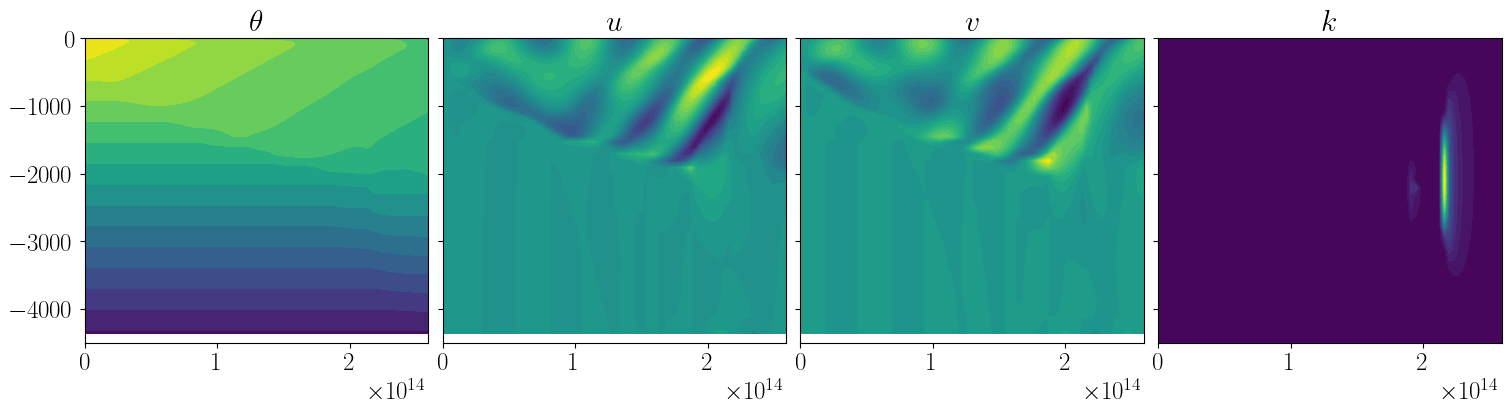

In [30]:



################################# PLOTTING
    
time_r_mesh, z_r_mesh= np.meshgrid(out[0]['ocean_time'], out[0]['z_r'])
time_w_mesh, z_w_mesh= np.meshgrid(out[0]['ocean_time'], out[0]['z_w'])





fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4),sharey=True, layout='constrained')
i=-1

# ===============================================================
i+=1
ax = axes.flat[i]
ax.set_title(r'$\theta$')
im = ax.contourf(time_r_mesh, z_r_mesh, out[0]['temp'].T , levels=15)

# ===============================================================
i+=1
ax = axes.flat[i]
ax.set_title(r'$u$')
im = ax.contourf(time_r_mesh, z_r_mesh, out[0]['u'].T , levels=30)

# ===============================================================
i+=1
ax = axes.flat[i]
ax.set_title(r'$v$')
im = ax.contourf(time_r_mesh, z_r_mesh, out[0]['v'].T , levels=30)

# ===============================================================
i+=1
ax = axes.flat[i]
ax.set_title(r'$k$')
im = ax.contourf(time_w_mesh, z_w_mesh, out[0]['tke'].T , levels=30)

plt.show()